In [1]:
# Magic incantations to make our ugly framework working
import sys
sys.path.insert(0, r'/SAPDevelop/QuoraPairs/BruteForce/Tools')

#import all our small tools
from Tools.all import *

# setup the nale of our experiment
# it will be used to store every result in a unique place
EXPERIENCE='TestAlain2'

# Build simple features

# First steps
* Train & Challenge: Read original data (minimal low level cleaning already done)
* Absolutely no preprocessing
* Train & Challenge: Compute basic features
    * Compute common_words between question1 & question2
    * Compute Nb common_words between question1 & question2
    * Compute Nb common words/nb words in question1
    * Compute Nb common words/nb words in question2
    * Compute Nb words in question1,question2 not in common words
    * Compute (nb common words)/(nb words in question1+nb word in question2)

In [2]:
def add_column_from_columns(dataframe,output_column_name,function):
    dataframe[output_column_name]=dataframe.progress_apply(function,axis=1)
    return dataframe[output_column_name]

def add_column_from_column(dataframe,output_column_name,input_column_name,function):
    dataframe[output_column_name]=dataframe[input_column_name].progress_apply(function)
    return dataframe[output_column_name]


def build_all_simple_features(dataframe):
    start_small()
    print_warning('Compute common_words between question1 & question2')
    add_column_from_column(dataframe,'nb_words_question1','question1',lambda x: len(x.split()))
    add_column_from_column(dataframe,'nb_words_question2','question2',lambda x: len(x.split()))
    print_warning('Compute Nb common_words between question1 & question2')
    add_column_from_columns(dataframe,'common_words',lambda r: list(set(r.question1.split())&set(r.question2.split())))
    add_column_from_column(dataframe,'nb_common_words','common_words',len)

    print_warning('Compute Nb common words/nb words in question1')
    add_column_from_columns(dataframe,'nb_common_words/nb_words_question1',lambda r: r.nb_common_words/max(1,r.nb_words_question1))
    print_warning('Compute Nb common words/nb words in question2')
    add_column_from_columns(dataframe,'nb_common_words/nb_words_question2',lambda r: r.nb_common_words/max(1,r.nb_words_question2))

    print_warning('Compute Nb words in question1,question2 not in common words')
    add_column_from_columns(dataframe,'nb_words_question1-common_words',lambda r: len(list(set(r.question1.split())-set(r.common_words))))
    add_column_from_columns(dataframe,'nb_words_question2-common_words',lambda r: len(list(set(r.question2.split())-set(r.common_words))))
    print_warning('Compute (nb common words)/(nb words in question1+nb word in question2)')
    add_column_from_columns(dataframe,'nb_common_words/(nb_words_question1+nb_words_question2)',lambda r: r.nb_common_words/(r.nb_words_question1+r.nb_words_question2))
    end_small()
    dataframe=dataframe.drop(columns='common_words')
    return dataframe

In [3]:
prepare_environnement('TestAlain')
train_dataframe=load_dataframe(CLEAN_TRAINING_DATA)
challenge_dataframe=load_dataframe(CLEAN_CHALLENGE_DATA)
print_section('Untouched input data has been loaded. Training: %d lines Challenge: %d lines' % (len(train_dataframe),len(challenge_dataframe)))

train_dataframe=load_or_build_dataframe('Training data + basic features','training_basic_features',build_all_simple_features,train_dataframe)
challenge_dataframe=load_or_build_dataframe('Challenge data + basic features','challenge_basic_features',build_all_simple_features,challenge_dataframe)

In [5]:
train_dataframe.head()[:1]

,id,qid1,qid2,question1,question2,is_duplicate,nb_words_question1,nb_words_question2,nb_common_words,nb_common_words/nb_words_question1,nb_common_words/nb_words_question2,nb_words_question1-common_words,nb_words_question2-common_words,nb_common_words/(nb_words_question1+nb_words_question2)
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0,14,12,10,0.714286,0.833333,2,1,0.384615


In [6]:
challenge_dataframe.head()[:1]

,test_id,question1,question2,nb_words_question1,nb_words_question2,nb_common_words,nb_common_words/nb_words_question1,nb_common_words/nb_words_question2,nb_words_question1-common_words,nb_words_question2-common_words,nb_common_words/(nb_words_question1+nb_words_question2)
0,0,How does the Surface Pro himself 4 compare with iPad Pro?,Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?,11,14,2,0.181818,0.142857,9,11,0.08


## Compute AUC of these basic features and try to figure if there is a bit of information

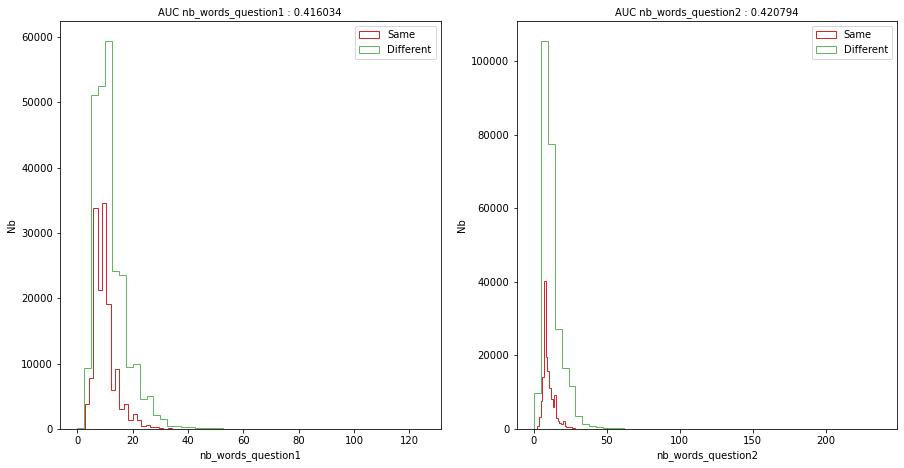

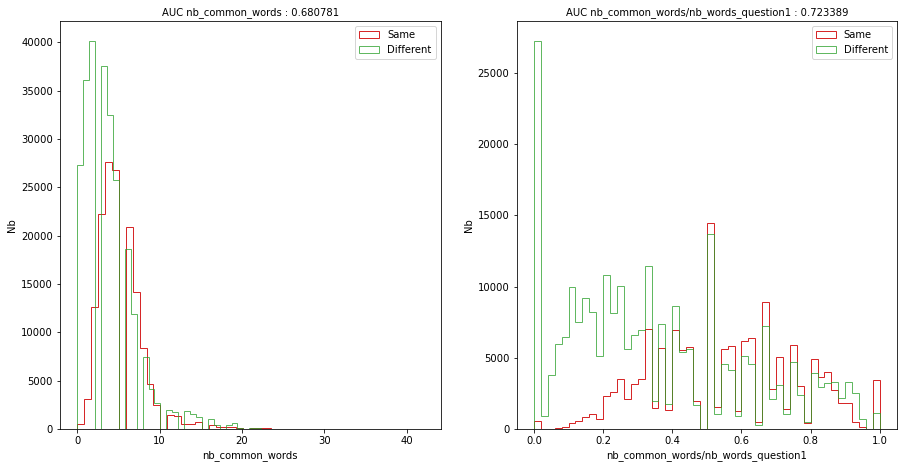

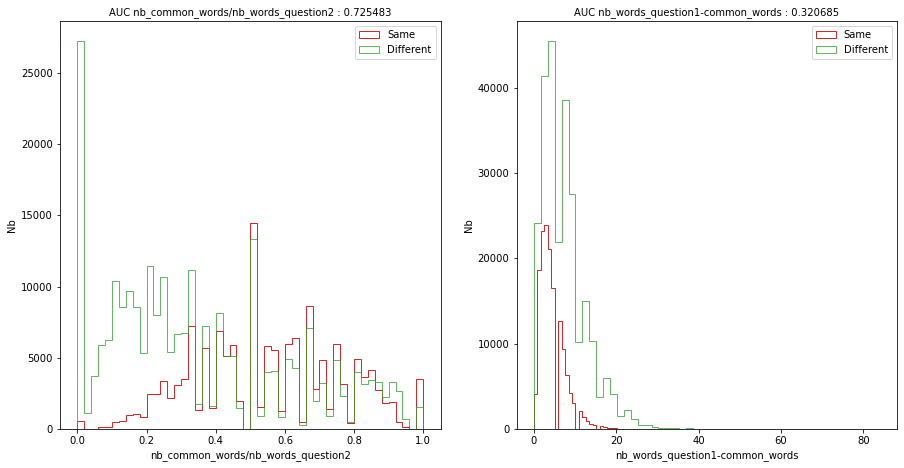

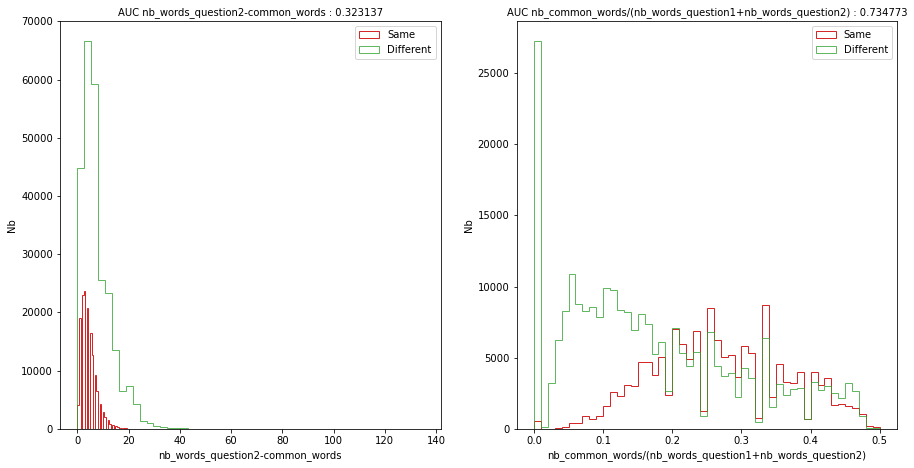

In [7]:
from sklearn.metrics import roc_auc_score

def simple_AUC(dataframe,column_name):
    return roc_auc_score(dataframe['is_duplicate'],dataframe[column_name])

def show_AUC(dataframe,column_name):
    print_bullet('AUC %s: %f' % (column_name,simple_AUC(dataframe,column_name)))

def display_simple_AUC(dataframe,column_name):
    palette = sns.color_palette()
    # Let multiplot_generator figure the size
    #plot.figure(figsize=(10, 7))
    plot.hist(dataframe[column_name][dataframe['is_duplicate']==1],bins=50,color=palette[3],label='Same',histtype='step')
    plot.hist(train_dataframe[column_name][dataframe['is_duplicate']==0],bins=50,color=palette[2],label='Different',alpha = 0.75,histtype='step')
    plot.title('AUC %s : %f' % (column_name,simple_AUC(dataframe,column_name)) , fontsize=10)
    plot.xlabel(column_name)
    plot.ylabel('Nb')
    plot.legend()


def show_all_simple_AUC(dataframe):
    all =  all_numeric_columns(dataframe)
    print_section( 'Show AUC on %d unique features' % len(all))
    for name in all:
        show_AUC(dataframe,name)
        yield
        display_simple_AUC(dataframe,name)
    print_done('Done')


def show_all_simple_AUC_in_grid(dataframe,nb_columns=2):
    multiplot_from_generator(show_all_simple_AUC(dataframe), nb_columns)

show_all_simple_AUC_in_grid(train_dataframe,nb_columns=2)



## As a quick check, Build simple naive bayes models (full & with test) on a fixed set of features

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# This will add a suffix to all keys of a dict
# Used to add _test,_train,_full to keys of infos about a model

FAKE_INFOS_ON_MODEL_TEST_TRAIN = {
    'accuracy_train': 0,
    'score_train': 0,
    'logloss_proba_train': 0,
    'model_train': None,
    'accuracy_test': 0,
    'score_test': 0,
    'logloss_proba_test': 0,
    'model_test': None,
    'time_test':0
}

FAKE_INFOS_ON_MODEL_FULL = {
    'accuracy_full': 0,
    'score_full': 0,
    'logloss_proba_full': 0,
    'model_full': None,
    'time_full': 0
}


PRINT_INFOS_ON_2_MODELS = {
    'accuracy_test': '%.4f',
    'score_test': '%.4f',
    'logloss_proba_test': '%.4f',
    'time_test': '%.1f',

    'accuracy_train': '%.4f',
    'score_train': '%.4f',
    'logloss_proba_train': '%.4f',

    'accuracy_full': '%.4f',
    'score_full': '%.4f',
    'logloss_proba_full': '%.4f',
    'time_full': '%.1f',

    'nb_features': '%d',
    'column_names': '%s'
}

PRINT_INFOS_ON_MODEL_TRAIN = {
    'accuracy_train': '%.4f',
    'score_train': '%.4f',
    'logloss_proba_train': '%.4f',
}

PRINT_INFOS_ON_MODEL_TEST = {
    'accuracy_test': '%.4f',
    'score_test': '%.4f',
    'logloss_proba_test': '%.4f',
    'time_test': '%.1f',
}

PRINT_INFOS_ON_MODEL_FULL = {
    'accuracy_full': '%.4f',
    'score_full': '%.4f',
    'logloss_proba_full': '%.4f',
    'time_full': '%.1f',

}

def add_suffix_to_keys(d,s):
    return dict(zip([k+s for k in d.keys()],d.values()))

def format_model_infos(message,keys_formats,infos):
    values = list()
    for k,f in keys_formats.items():
        values.append( f % infos[k])
    #return print_info( '%s %s' %(message,'&nbsp;|&nbsp;'.join(values)))
    return '%s %s' %(message,' | '.join(values))

def print_model_infos(message,keys_formats,infos):
    print_info(format_model_infos(message,keys_formats,infos))
def print_header_infos_model(key_formats):
    print_info('|'.join(key_formats.keys()))

## Use & trick FAKE_XXXXX to mock the big loop of big trainings 
def FAKE_build_naivebayes_model_full(input,column_names,target,show=True):
    return FAKE_INFOS_ON_MODEL_FULL

def FAKE_build_naivebayes_model_with_test(input,column_names,target,show=True):
    return FAKE_INFOS_ON_MODEL_TEST_TRAIN

def FAKE_build_model(train_dataframe,column_names,target,show=True):
    infos = FAKE_build_naivebayes_model_with_test(train_dataframe,column_names,target,show=show)
    infos.update(FAKE_build_naivebayes_model_full(train_dataframe,column_names,target,show=show))
    infos.update(
        {
            'nb_features':len(column_names),
            'column_names':clean_combination_name(column_names),
            'columns': column_names
        })
    return infos



def compute_metrics_model(model,input_df,target_df,suffix,show=True):
    prediction_df = model.predict(input_df)
    prediction_proba_df = model.predict_proba(input_df)
    res = metrics.classification_report(target_df,prediction_df,output_dict=True)
    accuracy = res['accuracy']
    score = res['0']['f1-score']*(1-0.17)+res['1']['f1-score']*.17
    logloss_proba = metrics.log_loss(target_df,prediction_proba_df)
    if show:
        print('Classification report on %s' % suffix)
        print(metrics.classification_report(target_df,prediction_df))
    return add_suffix_to_keys(
            {
             'accuracy':accuracy,
             'score':score,
             'logloss_proba':logloss_proba,
             'model':model
           },
           suffix)


def build_naivebayes_model_with_test(input,column_names,target,show=True):
    # print_bullet('Multinomial Naive Bayes with test on %s' % clean_combination_name(column_names))
    input_train = pandas.DataFrame()
    for column_name in column_names:
        input_train[column_name]=input[column_name]
    target_train = target
    input_train,input_test,target_train,target_test = train_test_split(input_train,target_train,random_state=42,test_size=0.2)
    if show:
        print_info( 'Training:%d lines Test:%d Nb Features: %d' % (len(input_train),len(input_test),len(input_train.columns)))
    model = MultinomialNB()
    #naive_bayes_classifier_with_test=ComplementNB()
    start = time.time()
    model.fit(input_train,target_train)
    duration = time.time()-start
    infos = compute_metrics_model(model,input_test,target_test,'_test',show=show)
    infos.update(compute_metrics_model(model,input_train,target_train,'_train',show=show))
    infos.update({'time_test':duration})
    if show:      
        print_model_infos('Test ',PRINT_INFOS_ON_MODEL_TEST,infos)
        print_model_infos('Train ',PRINT_INFOS_ON_MODEL_TRAIN,infos)
    return  infos
    
def build_naivebayes_model_full(input,column_names,target,show=True):
    input_full = pandas.DataFrame()
    for column_name in column_names:
        input_full[column_name] = input[column_name]
    if show:
        print_info( 'Training on %dx%d' % (len(input_full),len(input_full.columns)))
    target_full = target
    model = MultinomialNB()
    start = time.time()
    model.fit(input_full,target_full)
    duration = time.time()-start
    infos = compute_metrics_model(model,input_full,target_full,'_full',show=show)
    infos.update({'time_full':duration})
    if show:
        print_model_infos('Full ',PRINT_INFOS_ON_MODEL_FULL,infos)
    return infos


def build_model(train_dataframe,column_names,target,show=True):
    infos = build_naivebayes_model_with_test(train_dataframe,column_names,target,show=show)
    infos.update(build_naivebayes_model_full(train_dataframe,column_names,target,show=show))
    infos.update(
        {
            'nb_features':len(column_names),
            'column_names':clean_combination_name(column_names),
            'columns': column_names
        })
    return infos


build_model(train_dataframe,['nb_words_question1'],train_dataframe['is_duplicate'])



Classification report on _test
              precision    recall  f1-score   support

           0       0.63      1.00      0.77     50803
           1       0.00      0.00      0.00     30055

    accuracy                           0.63     80858
   macro avg       0.31      0.50      0.39     80858
weighted avg       0.39      0.63      0.48     80858

Classification report on _train
              precision    recall  f1-score   support

           0       0.63      1.00      0.77    204224
           1       0.00      0.00      0.00    119208

    accuracy                           0.63    323432
   macro avg       0.32      0.50      0.39    323432
weighted avg       0.40      0.63      0.49    323432



Classification report on _full
              precision    recall  f1-score   support

           0       0.63      1.00      0.77    255027
           1       0.00      0.00      0.00    149263

    accuracy                           0.63    404290
   macro avg       0.32      0.50      0.39    404290
weighted avg       0.40      0.63      0.49    404290



{'accuracy_test': 0.6282989932968909,
 'score_test': 0.640531212735738,
 'logloss_proba_test': 0.6598757918253548,
 'model_test': MultinomialNB(),
 'accuracy_train': 0.631427935392911,
 'score_train': 0.6424864684567217,
 'logloss_proba_train': 0.6581913334694939,
 'model_train': MultinomialNB(),
 'time_test': 0.04104781150817871,
 'accuracy_full': 0.630802146973707,
 'score_full': 0.6420960175454294,
 'logloss_proba_full': 0.6585273839844356,
 'model_full': MultinomialNB(),
 'time_full': 0.05285835266113281,
 'nb_features': 1,
 'column_names': 'nb_words_question1',
 'columns': ['nb_words_question1']}

## Build models (test & full) on all combinations of features

In [46]:
# bad design choice : a DataFrame can be more convenient than a dict
# But then, it is convenient to suppress all non numeric/string columns
def models_dict_to_df(models_dict):
    # reorder also the columns in a way I use more convenient
    return pandas.DataFrame.from_dict(models_dict, orient='index').reindex(columns=['logloss_proba_test','logloss_proba_train','logloss_proba_full','nb_features','column_names','accuracy_test','accuracy_train','accuracy_full','score_test','score_train','score_full','model_test','model_train','model_full','columns','time_test','time_full'])

def build_model_on_all_subset_of_simple_features(dataframe,target):
    start = time.time()
    print_section('%s : Build all models (with test+full) on every combination of simple features - %d lines' % (EXPERIMENT,len(dataframe)))
    models_dict = dict()
    print_header_infos_model(PRINT_INFOS_ON_2_MODELS)
    all_combinations = list(all_subsets(all_numeric_columns(dataframe)))
    progress = tqdm(all_combinations)
    for c in progress:
        #if (len(c)) ==1:
        if (len(c)) >0:
            infos = build_model(dataframe,c,target,show=False)
            models_dict[clean_combination_name(c)] = infos
            print_info(format_model_infos('',PRINT_INFOS_ON_2_MODELS,infos))
            progress.refresh()
    print_done('Done',top=start)
    # Design mistake : need to convert dict to dataframe :(
    return models_dict_to_df(models_dict)


def FAKE_build_model_on_all_subset_of_simple_features(dataframe,target):
    start = time.time()
    print_section('%s : Build all models (with test+full) on every combination of simple features - %d rows' % (EXPERIMENT,len(dataframe)))
    models_dict = dict()
    print_header_infos_model(PRINT_INFOS_ON_2_MODELS)
    all_combinations = list(all_subsets(all_numeric_columns(dataframe)))
    progress = tqdm(all_combinations)
    for c in progress:
        if (len(c)) >0:
            infos = FAKE_build_model(dataframe,c,target,show=False)
            models_dict[clean_combination_name(c)] = infos
            print_info(format_model_infos('',PRINT_INFOS_ON_2_MODELS,infos))
            progress.refresh()
    print_done('Done',top=start)
    # Design mistake : need to convert dict to dataframe :(
    return models_dict_to_df(models_dict)

def graph_all_metric_all_models(results,y_label,metric_sort,metrics):
    palette = sns.color_palette()
    data = results.sort_values(metric_sort+'_test',ascending=(metric_sort!='logloss_proba'))
    #ax = plot
    # fig,ax = plot.subplots()
    x = numpy.arange(len(data))
    num_col=1
    if len(metrics)>1:
        kinds =['_test']
    else:
        kinds = ['_test','_train','_full']
    for k in kinds:
        for m in metrics:
                plot.plot(x,data[m+k],color = palette[num_col],label = m+k)
                num_col = num_col+1
    plot.ylabel(y_label)
    #plot.plot(x,data['nb_features'],color=palette[num_col])
    plot.plot(x,data['time_full'],color = palette[num_col+1],label = 'time_full')
    plot.title(EXPERIMENT+':'+ y_label,fontsize=8)
    #plot.xticks(x)
    #ax.set_xticklabels(labels)
    plot.legend()


def graph_all_metrics_all_models(results):
    for m in ['accuracy','score','logloss_proba']:
        yield
        graph_all_metric_all_models(results,m,m,[m])
    yield
    graph_all_metric_all_models(results,'all metrics','logloss_proba',['accuracy','score','logloss_proba'])

def graph_all_metrics_all_models_in_grid(results,nb_columns=2):
    multiplot_from_generator(graph_all_metrics_all_models(results), nb_columns)

## If you want to quickly validate some code, activate this massive subsampling 
Results will be useless but code coverage will be ok

In [47]:
small_train_dataframe = train_dataframe.sample(20000)
small_models = build_model_on_all_subset_of_simple_features(small_train_dataframe,small_train_dataframe['is_duplicate'])


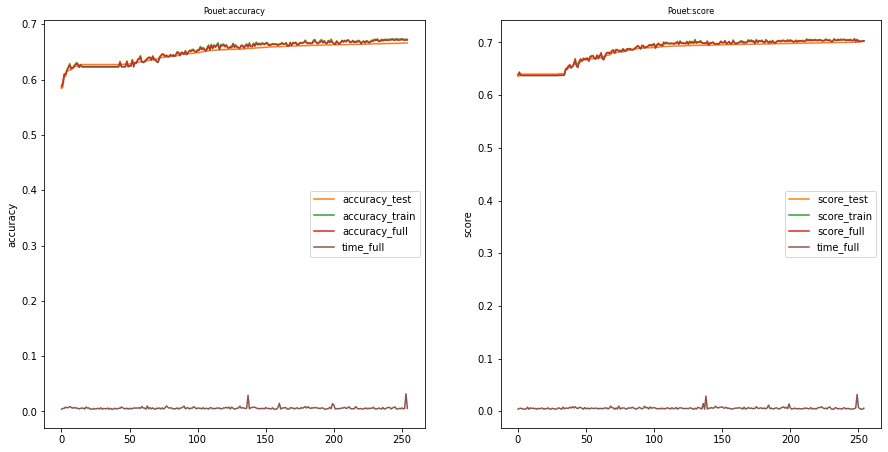

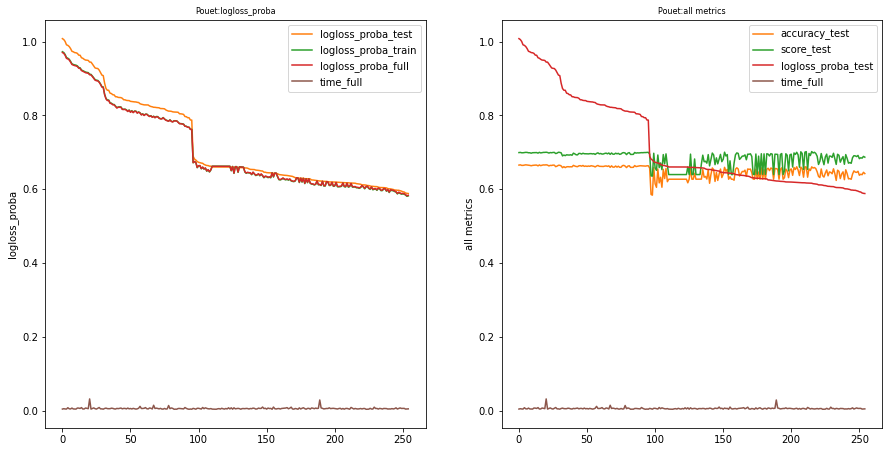

In [43]:
graph_all_metrics_all_models_in_grid(small_models,2)

## The big loop

In [26]:
# build ALL models
# Do not forget to keep the result !
# it's a dataframe with all infos on all models

# Use this line to mock up the loop
#FAKE_build_model_on_all_subset_of_simple_features(train_dataframe,train_dataframe['is_duplicate'])

model_results = build_model_on_all_subset_of_simple_features(train_dataframe,train_dataframe['is_duplicate'])


In [32]:
model_results.head().transpose()

,nb_words_question1,nb_words_question2,nb_common_words,nb_common_words/nb_words_question1,nb_common_words/nb_words_question2
logloss_proba_test,0.659876,0.659876,0.659876,0.659876,0.659876
logloss_proba_train,0.658191,0.658191,0.658191,0.658191,0.658191
logloss_proba_full,0.658527,0.658527,0.658527,0.658527,0.658527
nb_features,1,1,1,1,1
column_names,nb_words_question1,nb_words_question2,nb_common_words,nb_common_words/nb_words_question1,nb_common_words/nb_words_question2
accuracy_test,0.628299,0.628299,0.628299,0.628299,0.628299
accuracy_train,0.631428,0.631428,0.631428,0.631428,0.631428
accuracy_full,0.630802,0.630802,0.630802,0.630802,0.630802
score_test,0.640531,0.640531,0.640531,0.640531,0.640531
score_train,0.642486,0.642486,0.642486,0.642486,0.642486


## Graph metrics on all models generated

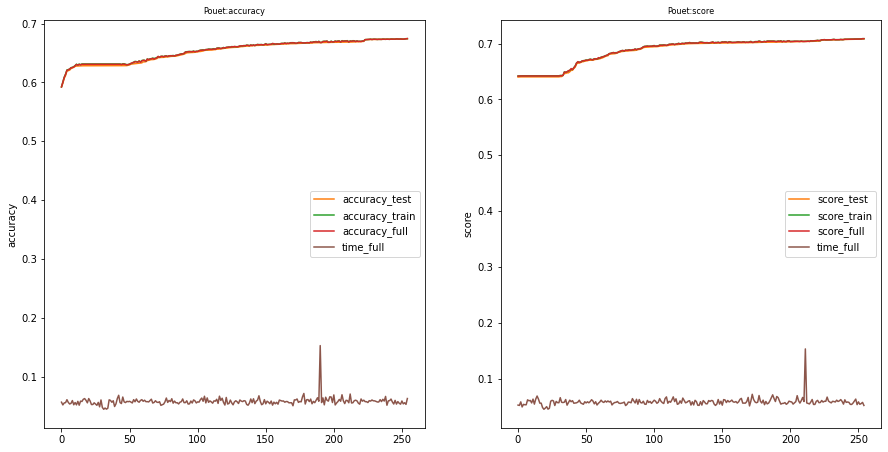

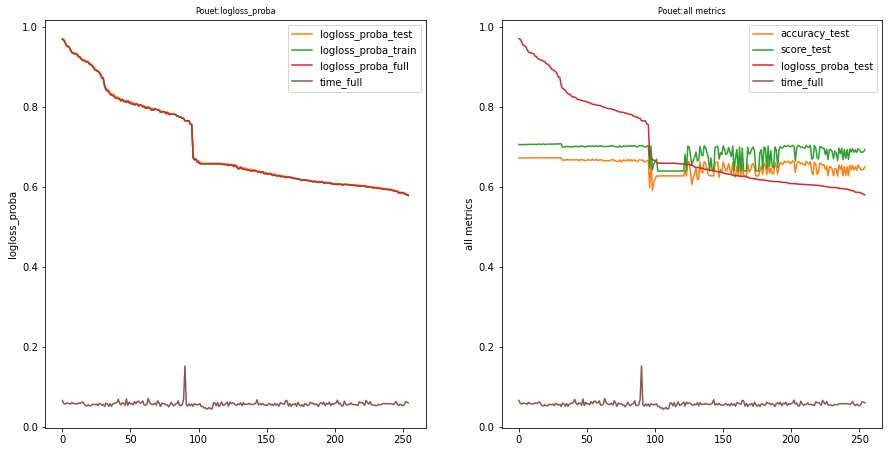

In [40]:

def graph_all_metric_all_models(results,y_label,metric_sort,metrics):
    palette = sns.color_palette()
    data = results.sort_values(metric_sort+'_test',ascending=(metric_sort!='logloss_proba'))
    #ax = plot
    # fig,ax = plot.subplots()
    x = numpy.arange(len(data))
    num_col=1
    if len(metrics)>1:
        kinds =['_test']
    else:
        kinds = ['_test','_train','_full']
    for k in kinds:
        for m in metrics:
                plot.plot(x,data[m+k],color = palette[num_col],label = m+k)
                num_col = num_col+1
    plot.ylabel(y_label)
    #plot.plot(x,data['nb_features'],color=palette[num_col],label='Nb features')
    plot.plot(x,data['time_full'],color = palette[num_col+1],label = 'time_full')
    plot.title(EXPERIMENT+':'+ y_label,fontsize=8)
    #plot.xticks(x)
    #ax.set_xticklabels(labels)
    plot.legend()


def graph_all_metrics_all_models(results):
    for m in ['accuracy','score','logloss_proba']:
        yield
        graph_all_metric_all_models(results,m,m,[m])
    yield
    graph_all_metric_all_models(results,'all metrics','logloss_proba',['accuracy','score','logloss_proba'])

def graph_all_metrics_all_models_in_grid(results,nb_columns=2):
    multiplot_from_generator(graph_all_metrics_all_models(results), nb_columns)
    
graph_all_metrics_all_models_in_grid(model_results,2)